<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Customer Segmentation with K-means Clustering and Data Preparation Pipelines with R and tdplyr
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction</b></p>

<b style = 'font-size:20px;font-family:Arial;'>Leverage native Vantage processing for efficient and highly scalable data preparation, model training, and evaluation workflows</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>K-means clustering is one of the most popular <b>unsupervised</b> machine learning algorithms.  Essentially, the algorithm seeks to group similar data points together by minimizing the average ("means" in K-means) distance for all data points from each cluster's center (centroid).</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Define the number of clusters (k)</li>
                <br>
                <li>The algorithm chooses random points as centroids</li>
                <br>
                <li>Each iteration attempts to optimize the centroid locations</li>
                <br>
                <li>Iterations end once the distances have stabilized or the max iteration count is reached</li>
            </ol>
        </td>
        <td><img src = 'images/K-means_convergence.gif' width = '250'></td>
    </tr>
</table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>One limitation of this algorithm is that it only accepts numeric data as feature input (categorical clustering can be performed using K-modes algorithm).  Typically, data engineers or data scientists will perform multiple <b>serial</b> steps to prepare a numeric-only data set that can be passed to the K-means algorithm.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage provides native "Fit and Transform" functions to assist in data preparation and transformation at scale.  To aid in efficiency and operationalization, Vantage provides a bulk <b>Column Transformer</b> function which can take multiple transformation directives at the same time, and act on the whole data set at once.  This allows for both process and code simplification, allowing more streamlined and robust operational deployment.</p> 

<img src = 'Flow_Diagram_KMeans.png' width = 100%>


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The data for this demonstration is based on online purchase history data set, which can be found <a href = 'https://www.kaggle.com/code/hellbuoy/online-retail-k-means-hierarchical-clustering/data'>here</a>.  The goal is to segment the customers by purchase volume and value.  Steps are as follow:</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Analyze the raw data, split a testing set</li>
                <br>
                <li>Engineer numeric features</li>
                <br>
                <li>Build the K-means model</li>
                <br>
                <li>Apply in-line transformation to the testing set</li>
                <br>
                <li>Make Predictions and evaluate model accuracy</li>
            </ol>
        </td>
        <td><img src = 'images/clustering_img.png' width = '250'></td>
    </tr>
</table>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>First we import the required libraries, set environment variables and environment paths (if required).</p>

In [1]:
suppressMessages(install.packages("dbplot", quiet = TRUE))

<div class="alert alert-block alert-info">
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Note: </b><i>The above statement will install the required libraries and may give a message about the installation. In case of any message please make sure its just a message or a warning and not any error. After installation make sure to restart the kernel. The simplest way to restart the Kernel is by typing zero zero: <b> 0 0</b></i></p>
</div>

In [2]:
suppressWarnings(suppressMessages({
library(tdplyr)
library(dbplyr)
library(dplyr)
library(DBI) 
library(ggplot2)   
library(dbplot)    
    }))

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will be prompted to provide the password. We will enter the password, press the Enter key, and then use the down arrow to go to the next cell.</p>

In [3]:
con <- td_create_context(host = 'host.docker.internal', uid = "demo_user", pwd = getPass("Enter your password: "), dType = "NATIVE", logmech = "TD2")

Enter your password:  ········


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>

In [4]:
dbExecute(con,"SET query_band='DEMO=K-Means_Clustering_and_ML_model_R.ipynb;' UPDATE FOR SESSION;") 

[1] 1

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage. We have the option of either running the demo using foreign tables to access the data without using any storage on our environment or downloading the data to local storage, which may yield somewhat faster execution. However, we need to consider available storage. There are two statements in the following cell, and one is commented out. We may switch which mode we choose by changing the comment string.</p>

In [5]:
#dbExecute(con,"call get_data('DEMO_Retail_cloud');") 
dbExecute(con,"call get_data('DEMO_Retail_local');") 

[1] 0

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Access data in Vantage  </b> </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>For this demo, data is already resident in Object Storage which we are accessing via ReadNOS, create a reference to the table, and sample the contents using the get_data procedure used above.  Data could just as easily reside in permanent tables, another RDBMS, or another Vantage system.</p>

In [6]:
top_df <- dbGetQuery(con, "SELECT TOP 5 * FROM DEMO_Retail.UK_Retail_Data;")
top_df

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<int64>,<dttm>,<dbl>,<dbl>,<chr>
555550,21830,ASSORTED CREEPY CRAWLIES,24,2011-05-06 13:29:00,0.42,15245,United Kingdom
555550,21916,SET 12 RETRO WHITE CHALK STICKS,48,2011-05-06 13:29:00,0.42,15245,United Kingdom
555550,22383,LUNCH BAG SUKI DESIGN,10,2011-05-06 13:29:00,1.65,15245,United Kingdom
555550,22382,LUNCH BAG SPACEBOY DESIGN,10,2011-05-06 13:29:00,1.65,15245,United Kingdom
555550,21166,COOK WITH WINE METAL SIGN,12,2011-05-06 13:29:00,2.08,15245,United Kingdom


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. Data Preparation</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we will inspect the original data set, and perform various preparation tasks.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Inspect the rows of the table</li>
    <li>Inspect the column metadata using <a href = 'https://docs.teradata.com/search/all?query=td_column_summary_sqle&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>ColumnSummary</a></li>
    <li>Split off a testing data set to be used in evaluation</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>2.1 View Column information</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><a href = 'https://docs.teradata.com/search/all?query=td_column_summary_sqle&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>ColumnSummary</a> provides more details on column values and ranges</p>

In [7]:
tdf <- tbl(con, in_schema("DEMO_Retail", "UK_Retail_Data"))
sprintf("No of Rows :%s",td_nrow(tdf))

[1] "No of Rows :536641"

In [8]:
column_names <- colnames(tdf)
obj <- td_column_summary_sqle(data=tdf,
                        target.columns=(column_names)
                       )
print(obj$result, width =Inf)

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598465879735"> [8 x 10]
# Database: Teradata
  ColumnName  Datatype                          NonNullCount NullCount
  <chr>       <chr>                                  <int64>   <int64>
1 StockCode   VARCHAR(10) CHARACTER SET UNICODE       536641         0
2 Quantity    BIGINT                                  536641         0
3 UnitPrice   FLOAT                                   536641         0
4 InvoiceNo   VARCHAR(10) CHARACTER SET UNICODE       536641         0
5 CustomerID  FLOAT                                   401604         0
6 Description VARCHAR(40) CHARACTER SET UNICODE       536641         0
7 Country     VARCHAR(25) CHARACTER SET UNICODE       536641         0
8 InvoiceDate TIMESTAMP(6)                            536641         0
  BlankCount ZeroCount PositiveCount NegativeCount NullPercentage
     <int64>   <int64>       <int64>       <int64>          <dbl>
1          0        NA            NA            NA         

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>2.2 Create a Testing data set</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From our sample data we are selecting some "Customer ID" values for testing later.</p>

In [9]:
dbExecute(con,"REPLACE VIEW UK_Retail_Test_V as (
    SELECT * FROM DEMO_Retail.UK_Retail_Data 
    WHERE CustomerID IN ('17307', '12503', '18268', '12908', '13693')
);") 

[1] 0

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Feature Engineering</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage provides many inDb feature engineering functions, in this section we will see how to prepare the data set for model training.  We will use "Fit" functions available in the tdplyr package to create input for the <a href = 'https://docs.teradata.com/search/all?query=column+transformer&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>ColumnTransformer</a> function to take as input in order to execute a bulk transformation.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Create a per-customer grouping of data</li>
    <li>Create Fit Tables
        <ul><li>Remove Outliers</li>
            <li>Impute Missing Values</li>
            <li>Create New Numeric Features</li>
            <li>Rescale the Data Set</li>
        </ul></li>
    <li>Call the final Transformation function</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>3.1 Create a per-customer table</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Simple GROUP BY, exclude the testing IDs.<br> Note there are 4368 unique customers in this training set.</p>

In [10]:
sql <- "
REPLACE VIEW Customer_ID_Group_V AS (
    SELECT CustomerID,
           SUM(quantity) as TotalQuantity, 
           SUM(UnitPrice) as TotalPrice, 
           COUNT(DISTINCT StockCode) as TotalItems 
    FROM DEMO_Retail.UK_Retail_Data
    WHERE CustomerID NOT IN ('17307', '12503', '18268', '12908', '13693')
    GROUP BY CustomerID
);"
dbExecute(con, sql)

[1] 0

In [11]:
tdf2 <- tbl(con, in_schema("DEMO_user", "Customer_ID_Group_V"))
sprintf("No of Rows :%s",td_nrow(tdf2))

[1] "No of Rows :4368"

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>3.2 Create Fit Tables</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage <a href = 'https://docs.teradata.com/search/all?query=Feature+Engineering+Transform+Functions&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>Feature Engineering Transform Functions</a> Use a "Fit and Transform" approach to make processing more modular and efficient.  "Fit tables" can be used as input to either individual Transform functions, or passed to a single <a href = 'https://docs.teradata.com/search/all?query=column+transformer&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>ColumnTransformer</a> function.</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Fit outlier removal using <a href = 'https://docs.teradata.com/search/all?query=OutlierFilterFit&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>OutlierFilterFit</a></li>
    <li>Fit a simple imputer to replace missing values using <a href = 'https://docs.teradata.com/search/all?query=simpleimputefit&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>SimpleImputeFit</a></li>
    <li>Fit column calculations to create new features using <a href = 'https://docs.teradata.com/search/all?query=NonLinearCombineFit&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>NonLinearCombineFit</a></li>
    <li>Call <a href = 'https://docs.teradata.com/search/all?query=column+transformer&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>ColumnTransformer</a> to execute the transformations (to allow for Scaling)</li>
    <li>Rescale the data using <a href = 'https://docs.teradata.com/search/all?query=ScaleFit&filters=prodname~%2522Teradata+Package+for+R%2522&content-lang=en-US'>ScaleFit/Transform</a></li>
            </ul></td>
        <td><img src = 'images/fit_transform.png' width = '300'></td>
    </tr>
    </table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>OutlierFilterFit</b> function calculates the lower_percentile, upper_percentile, count of rows and median for the specified input table columns. The calculated values for each column help the
    <b>OutlierFilterTransform</b> function detect outliers in the input table.

In [12]:
#Remove Outliers
#Trim below 3rd, and above 97th percentile

 outlierfit_obj <- td_outlier_filter_fit_sqle(
                data=tdf2,
                target.columns=c('TotalQuantity','TotalPrice'),
                lower.percentile=0.03,
                upper.percentile=0.97,
                outlier.method="PERCENTILE",
                replacement.value="MEDIAN",
                percentile.method="PERCENTILECONT")
outlierfit_obj$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598471366527"> [2 x 11]
# Database: Teradata
  TD_OUTLIERMETHOD_OFTFIT TD_IQRMULTIPLIER_OFTFIT TD_REMOVETAIL_OFTFIT
  <chr>                                     <dbl> <chr>               
1 PERCENTILE                                  1.5 BOTH                
2 PERCENTILE                                  1.5 BOTH                
# ℹ 8 more variables: TD_REPLACEMENTVALUE_OFTFIT <chr>,
#   TD_MINTHRESHOLD_OFTFIT <dbl>, TD_MAXTHRESHOLD_OFTFIT <dbl>,
#   TD_ATTRIBUTEVALUE_OFTFIT <chr>, TD_COUNTVALUE_OFTFIT <int64>,
#   TD_MEDIANVALUE_OFTFIT <dbl>, TD_LOWERPERCENTILE_OFTFIT <dbl>,
#   TD_UPPERPERCENTILE_OFTFIT <dbl>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>SimpleImputeFit </b>will output a table with the values that will be used to substitute the missing values<br>
    <b>SimpleImputeTransform</b> will return the input data set with the missing values filled in.

In [13]:
#Impute Missing Values
#Replace any missing CustomerID with a specific value

imputefit_obj <- td_simple_impute_fit_sqle(data=tdf2,
                                         literals.columns="CustomerID",
                                         literals="19000")
imputefit_obj$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598473867916"> [1 x 5]
# Database: Teradata
  TD_INDEX_SIMFIT TD_TARGETCOLUMN_SIMFIT TD_NUM_COLVAL_SIMFIT
            <int> <chr>                                 <dbl>
1               0 CustomerID                            19000
# ℹ 2 more variables: TD_STR_COLVAL_SIMFIT <chr>, TD_ISNUMERIC_SIMFIT <int>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>NonLinearCombineFit</b> function returns the target columns and a specified formula which uses the non-linear combination of existing features.


In [14]:
# Create a new column by multiplying quantity and price

nonlinearfit_out <- td_non_linear_combine_fit_sqle(
                                                  data = tdf2,
                                                  target.columns = c('TotalQuantity','TotalPrice'),
                                                  formula = "Y = X1*X0",
                                                  result.column = "TotalSales")
nonlinearfit_out$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598477422650"> [1 x 3]
# Database: Teradata
  TotalSales TotalQuantity TotalPrice
  <chr>            <int64>      <dbl>
1 Y = X1*X0             NA         NA

In [15]:
# Create another new column by diving the total sales by the number of unique items

nonlinearfit2_out <- td_non_linear_combine_fit_sqle(
                                                  data = tdf2,
                                                  target.columns = c('TotalQuantity','TotalPrice','TotalItems'),
                                                  formula = "Y = (X0*X1)/X2",
                                                  result.column = "SalesPerItem")
nonlinearfit2_out$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598480788991"> [1 x 4]
# Database: Teradata
  SalesPerItem   TotalQuantity TotalPrice TotalItems
  <chr>                <int64>      <dbl>      <int>
1 Y = (X0*X1)/X2            NA         NA         NA

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>The ColumnTransformer</b> function transforms the entire dataset in a single operation. You only need to provide the FIT tables to the function, and the function runs all transformations that you require in a
single operation. Running all the it table transformations together in one-go gives approx. 30% performance improvement over running each transformation sequentially.</p>

In [16]:
# Execute ColumnTransformer to build the data set

coltrans_out <- 
      td_column_transformer_sqle(
       input.data=tdf2,
       outlierfilter.fit.data=outlierfit_obj$result,
       simpleimpute.fit.data=imputefit_obj$result,
       nonlinearcombine.fit.data=nonlinearfit_out$result)
coltrans_out$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598484687191"> [?? x 5]
# Database: Teradata
   CustomerID TotalQuantity TotalPrice TotalItems TotalSales
        <dbl>       <int64>      <dbl>      <int>      <dbl>
 1      17614           235      219.          97    51385. 
 2      12957          2531      691.         208  1749503. 
 3      14288           187       60.8         16    11379. 
 4      16830           264       49.0         23    12933. 
 5      16168          1888      329.          57   621473. 
 6      14090            72      129.           1       76.3
 7      14680           365      776.          83  9683691. 
 8      15270          1459      292.          22   425678. 
 9      12910          1692      157.          48   265576. 
10      13500           585      238.          60   139382. 
# ℹ more rows

In [17]:
tdf3 <- coltrans_out$result
tdf4 <- td_non_linear_combine_transform_sqle(
                                             data=tdf3,
                                             object=nonlinearfit2_out,
                                             accumulate=colnames(tdf3))
tdf4$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598493616862"> [?? x 6]
# Database: Teradata
   CustomerID TotalQuantity TotalPrice TotalItems TotalSales SalesPerItem
        <dbl>         <dbl>      <dbl>      <dbl>      <dbl>        <dbl>
 1      17614           235      219.          97    51385.          530.
 2      12957          2531      691.         208  1749503.         8411.
 3      14288           187       60.8         16    11379.          711.
 4      16830           264       49.0         23    12933.          562.
 5      16168          1888      329.          57   621473.        10903.
 6      14090            72      129.           1       76.3        9294.
 7      14680           365      776.          83  9683691.         3414.
 8      15270          1459      292.          22   425678.        19349.
 9      12910          1692      157.          48   265576.         5533.
10      13500           585      238.          60   139382.         2323.
# ℹ more rows

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>ScaleFit and ScaleTransform </b>scales specified input
table columns i.e perform the specific scale methods like standard deviation, mean etc to the input columns </p> 

In [18]:
# ScaleFit/Transform to rescale the data
scalefit_obj <- td_scale_fit_sqle(data=tdf4$result,
                                 target.columns=c('TotalQuantity','TotalItems','TotalPrice','TotalSales','SalesPerItem'),
                                 scale.method="RANGE",
                                 miss.value="KEEP",
                                 global.scale=FALSE,
                                 multiplier="1",
                                 intercept="0")

In [19]:
tdf5 <- td_scale_transform_sqle(data=tdf4$result,
                                   object=scalefit_obj$result,
                                   accumulate="CustomerID")
tdf5$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598511463243"> [?? x 6]
# Database: Teradata
   CustomerID TotalQuantity TotalItems TotalPrice  TotalSales SalesPerItem
        <dbl>         <dbl>      <dbl>      <dbl>       <dbl>        <dbl>
 1      12649        0.115     0.00785     0.0624 0.000000473     0.00297 
 2      13349        0.0421    0.00406     0.0449 0.000000353     0.00161 
 3      16434        0.154     0.0236      0.268  0.00000121      0.00544 
 4      17614        0.0442    0.0260      0.165  0.000000478     0.000931
 5      16168        0.391     0.0152      0.251  0.00000242      0.0196  
 6      14090        0.0101    0           0.0952 0.000000304     0.0167  
 7      14680        0.0715    0.0222      0.599  0.0000332       0.00613 
 8      15270        0.301     0.00568     0.222  0.00000175      0.0348  
 9      12957        0.525     0.0560      0.533  0.00000625      0.0151  
10      14288        0.0342    0.00406     0.0421 0.000000342     0.00126 
#

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Above are the final values which we will now input to the model. </p> 

<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. Build the K-means Model</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As discussed above, the K-means algorithm takes a number of clusters "k", chooses a random starting point for each centroid, and iterates until a hard limit, or an optimum value is reached.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Finding an Ideal value for K</b></p>
<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The example below uses a value of 5 for the number of clusters to build the model against.  Typically, data scientists will build the model using various values for "k", and plot the "WCSS" (Within Cluster Sum-of-Squares) value on a series of each value chosen for k.  The "elbow" point (where the slope changes) is usually a good value for k.  <a href = 'https://docs.teradata.com/search/all?query=Kmeans&filters=prodname~%2522Teradata+Package+for+R%2522&sort=last_update&content-lang=en-US'>KMeans</a> function will return this value as "TotalWithinSS : ###" as a row in the "td_modelinfo_kmeans" column.</p></td>
        <td><img src = 'images/WCSS_elbow.png' width = '300'></td>
    </tr>
    </table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Other Function Parameters Include (but are not limited to)</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Input Table</li>
    <li>StopThreshold - The algorithm converges if the distance between the centroids from the previous iteration and the current iteration is less than the specified value.</li>
    <li>MaxIterNum</li>Specify the maximum number of iterations for the K-means algorithm. The algorithm stops after performing the specified number of iterations even if the convergence criterion is not met.
    </ul>

In [20]:
KMeans_out <- td_kmeans_sqle(id.column="CustomerID",
                                 target.columns=c('TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem'),
                                 data=tdf5$result,
                                 num.clusters=5,
                                 iter.max = 500)
KMeans_out$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598518675153"> [?? x 10]
# Database: Teradata
   td_clusterid_kmeans TotalQuantity TotalPrice TotalItems   TotalSales
               <int64>         <dbl>      <dbl>      <dbl>        <dbl>
 1                   2        0.193      0.220     0.0217   0.00000164 
 2                   4        0.269      0.637     0.0441   0.00000825 
 3                  NA       NA         NA        NA       NA          
 4                  NA       NA         NA        NA       NA          
 5                  NA       NA         NA        NA       NA          
 6                  NA       NA         NA        NA       NA          
 7                  NA       NA         NA        NA       NA          
 8                  NA       NA         NA        NA       NA          
 9                   3        0.0432     0.0290    0.00389  0.000000343
10                   1        0.621      0.306     0.0410   0.00000915 
# ℹ more rows
# ℹ 5 more variables: 

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From the generated model we can see how many ids are there in each cluster, what is the size of each cluster, number of iterations it took for model to converge etc.
    

In [21]:
selected_df <- as.data.frame(KMeans_out$model.data, width = Inf) %>%
  slice(1:5) %>%
  select(td_clusterid_kmeans, td_size_kmeans)

In [22]:
selected_df

td_clusterid_kmeans,td_size_kmeans
<int64>,<int64>
0,1271
1,288
2,964
3,1494
4,351


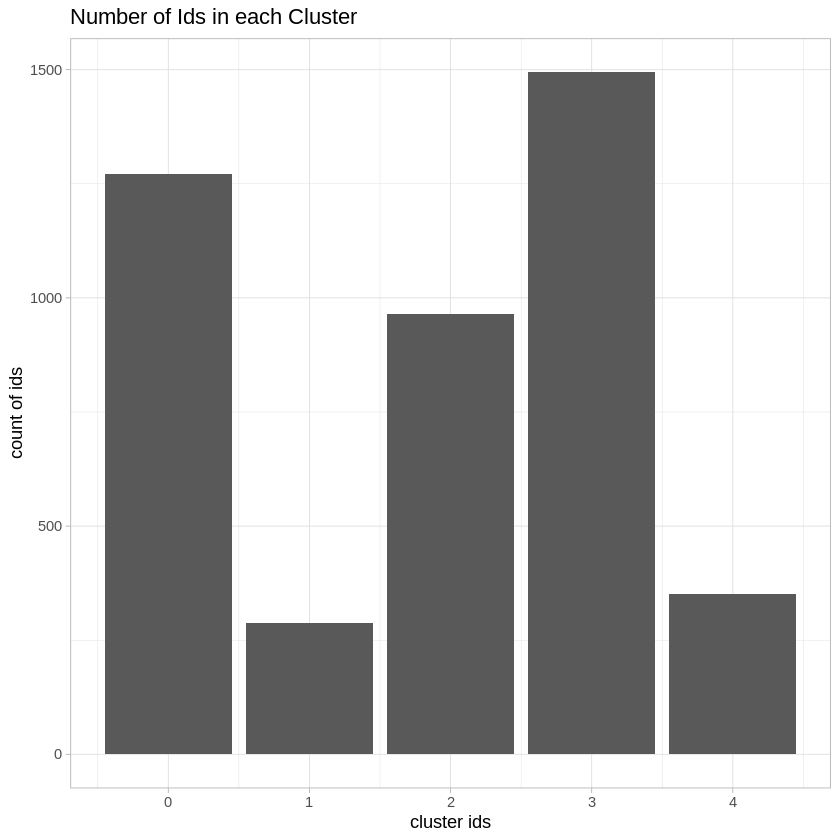

In [23]:
dbplot_bar(selected_df, x = as.integer(td_clusterid_kmeans), y=as.integer(td_size_kmeans))+
  labs(title = "Number of Ids in each Cluster",x = "cluster ids",y = "count of ids") +
  theme_light()#also changing the theme

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above barchart shows the number of ids in each cluster where cluster_id is 0-4 generated by the Kmeans function.

In [24]:
KMeansPredict_out <- td_kmeans_predict_sqle(object=KMeans_out$result,
                                                data=tdf5$result,
                                           accumulate=c('TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem'),
                                           output.distance=TRUE)
print(KMeansPredict_out$result, width = Inf)

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598532385713"> [?? x 8]
# Database: Teradata
   CustomerID td_clusterid_kmeans td_distance_kmeans TotalQuantity TotalPrice
        <dbl>             <int64>              <dbl>         <dbl>      <dbl>
 1      12649                   0             0.0732        0.115      0.0624
 2      16168                   2             0.200         0.391      0.251 
 3      14090                   0             0.0548        0.0101     0.0952
 4      14680                   4             0.203         0.0715     0.599 
 5      13349                   3             0.0159        0.0421     0.0449
 6      16434                   2             0.0617        0.154      0.268 
 7      17614                   0             0.0589        0.0442     0.165 
 8      17065                   0             0.0756        0.0715     0.0822
 9      12957                   1             0.247         0.525      0.533 
10      14288                   3          

In [25]:
tdf6 <- KMeansPredict_out$result

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5. PCA</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Principal Component Analysis (PCA) is a technique used for dimensionality reduction in data analysis and machine learning. It works by transforming the original high-dimensional data into a lower-dimensional space while retaining as much of the original variance as possible. PCA achieves this by identifying the principal components, which are the directions in feature space along which the data varies the most. These principal components are computed as the eigenvectors of the covariance matrix of the standardized data, and they represent the most significant sources of variation in the data. By selecting a subset of the principal components that capture the most variance, PCA allows for a more compact representation of the data while preserving its essential structure and relationships. The transformed data can be used for visualization, feature extraction, noise reduction, and other analysis tasks, making PCA a powerful tool for data exploration and dimensionality reduction.</p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will use the <a href = 'https://docs.teradata.com/search/all?query=pca&filters=prodname~%2522Teradata+Package+for+R%2522&sort=last_update&content-lang=en-US'>PCA</a>  function available in the Valib library for our analysis.</p> 

In [26]:
options(val.install.location = "val")

In [27]:
pca_obj <- td_pca_valib(data=tdf6,
                    columns=c('TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem'))
pca_obj$result

# Source:   table<"DEMO_USER"."r__t__valib_td_pca_valib1725598541119930"> [1 x 4]
# Database: Teradata
  partid mfactors modelstatus xmlmodel                                          
   <int>    <int> <chr>       <chr>                                             
1      1        2 SUCCEEDED   "<?xml version=\"1.0\" encoding=\"UTF-8\" standal…

In [28]:
obj <- td_pca_predict_valib(data=tdf6,
                            model=pca_obj$result,
                            index.columns="CustomerID",
                            accumulate=c('td_clusterid_kmeans'))
obj$result

# Source:   table<"DEMO_USER"."r__t__valib_td_pca_predict_valib1725598561591593"> [?? x 4]
# Database: Teradata
   CustomerID td_clusterid_kmeans `Factor 1` `Factor 2`
        <dbl>             <int64>      <dbl>      <dbl>
 1      15263                   3  -0.781       -0.296 
 2      16358                   2   0.337        0.140 
 3      15737                   2   0.0845       0.0471
 4      16792                   3  -0.786       -0.299 
 5      14723                   4   1.06        -0.138 
 6      12473                   1   0.896        0.211 
 7      12717                   2   0.000281     0.0551
 8      14479                   3  -0.686       -0.266 
 9      16114                   3  -0.832       -0.310 
10      12620                   2   0.286        0.0457
# ℹ more rows

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From above we can see that we have reduced our columns to two Factors using the PCA function. Now let us visualize these to see how our clusters are looking.</p>

Warning message:
“Removed 1 rows containing missing values (geom_point).”


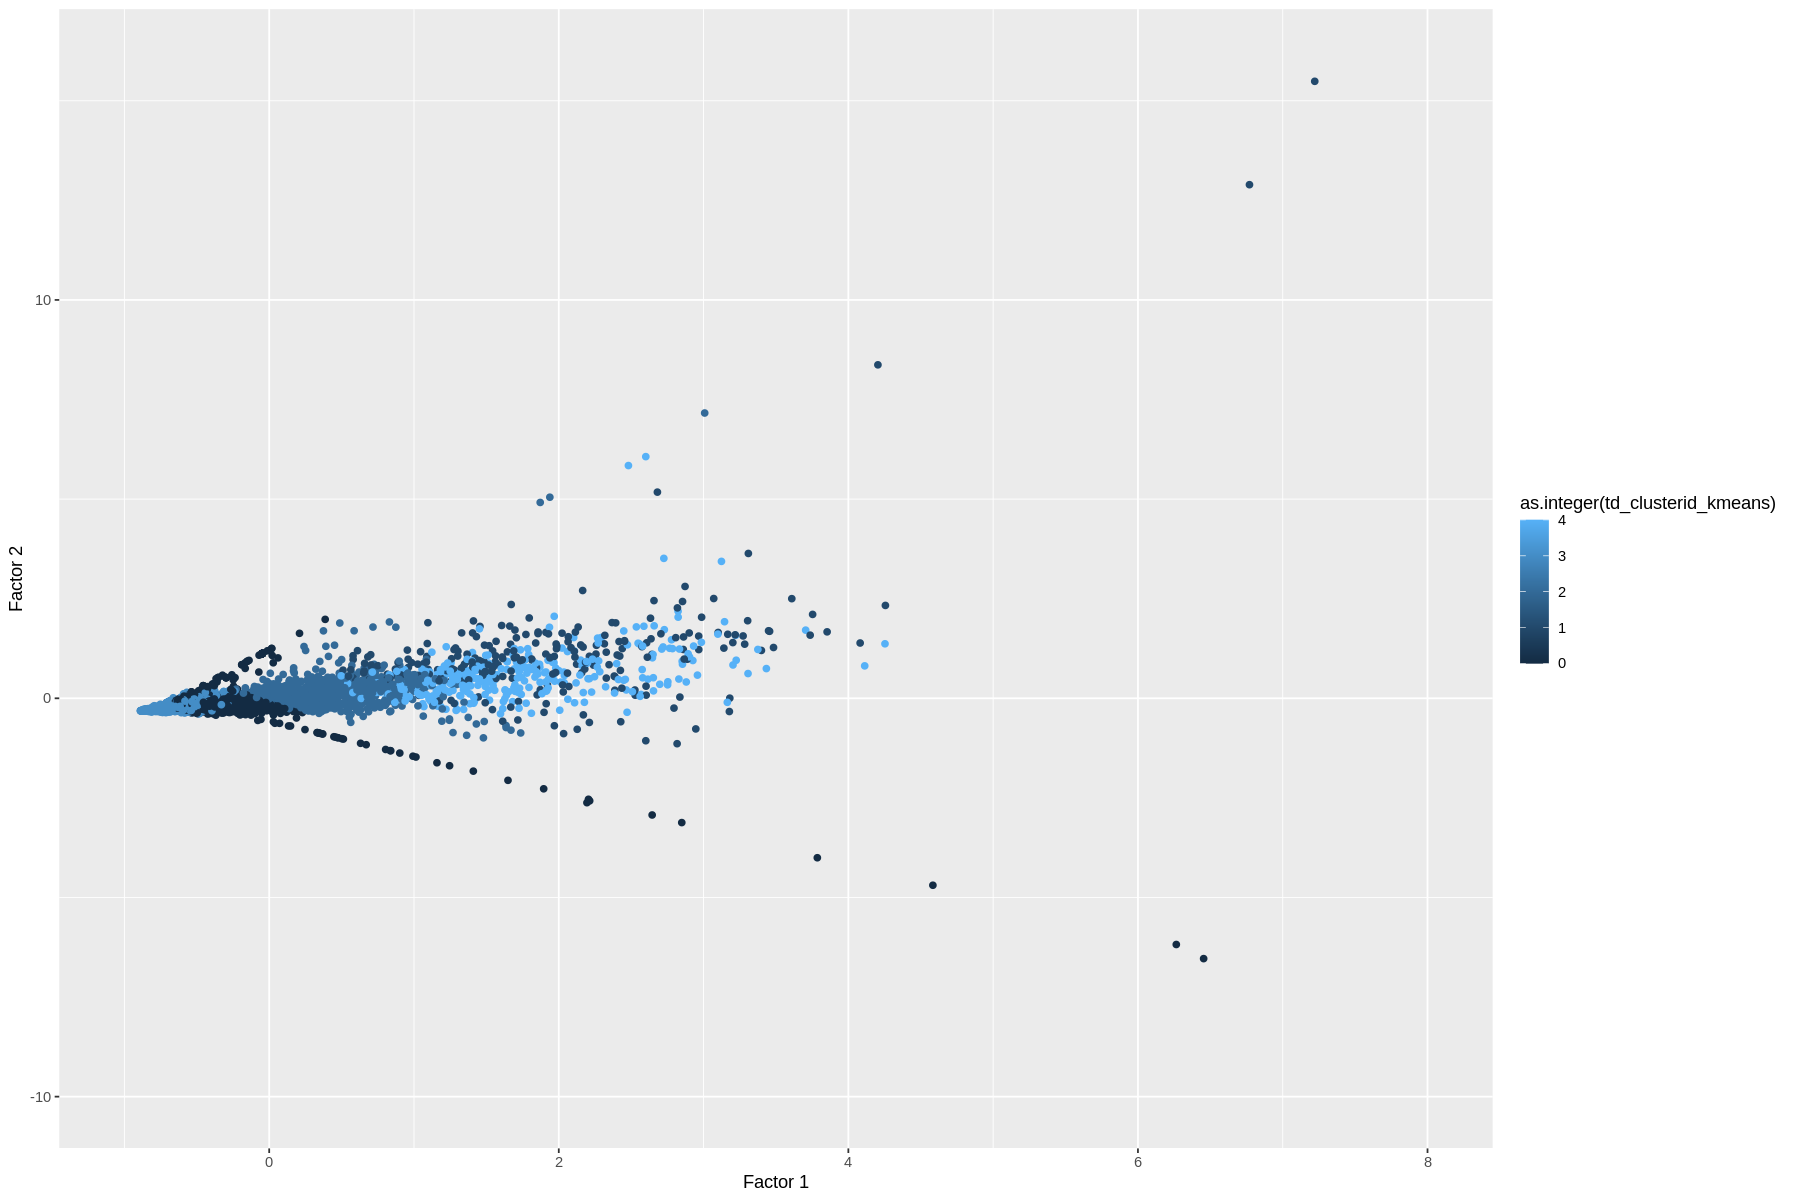

In [29]:
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(obj$result, aes(x=`Factor 1`, y=`Factor 2`)) + 
    geom_point(aes(color=as.integer(td_clusterid_kmeans))) + xlim(-1,8) +ylim(-10,16) 

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> In the above chart we have plotted the two factors generated by the PCA analysis.

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6. Bulk Transformation</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, the Fit tables created above will be passed to a single <a href = 'https://docs.teradata.com/search/all?query=columntransformer&filters=prodname~%2522Teradata+Package+for+R%2522&sort=last_update&content-lang=en-US'>ColumnTransformer</a> function.  This is similar to an operational approach, where a single query will prepare new or incoming data for immediate analysis.</p>

<img src = 'images/column_transformer.png' width = '300'>

In [30]:
test_tdf <- tbl(con, "UK_Retail_Test_V")
test_tdf

# Source:   table<"UK_Retail_Test_V"> [?? x 8]
# Database: Teradata
   InvoiceNo StockCode Description        Quantity InvoiceDate         UnitPrice
   <chr>     <chr>     <chr>               <int64> <dttm>                  <dbl>
 1 542694    15036     "ASSORTED COLOURS…      600 2011-01-31 12:37:00      0.53
 2 C541498   22776     "SWEETHEART CAKES…       -1 2011-01-18 15:21:00      9.95
 3 C541499   84819     "DANISH ROSE ROUN…       -1 2011-01-18 15:23:00      4.25
 4 C541499   22325     "MOBILE VINTAGE H…       -3 2011-01-18 15:23:00      4.95
 5 C570708   M         "Manual"               -600 2011-12-10 10:11:00      0.19
 6 C540271   M         "Manual"                 -1 2011-06-01 11:51:00   1126   
 7 557092    15036     "ASSORTED COLOURS…      600 2011-06-16 15:39:00      0.72
 8 C541499   22766     "PHOTO FRAME CORN…       -1 2011-01-18 15:23:00      2.95
 9 C542693   15036     "ASSORTED COLOURS…     -600 2011-01-31 12:36:00      0.65
10 561680    84968A    "SET OF 16 VINTAG…

In [31]:
sql <- "
REPLACE VIEW Customer_ID_Group_Test_V AS (
    SELECT CustomerID,
           SUM(quantity) as TotalQuantity, 
           SUM(UnitPrice) as TotalPrice, 
           COUNT(DISTINCT StockCode) as TotalItems 
    FROM DEMO_USER.UK_Retail_Test_V
    GROUP BY CustomerID
);"
dbExecute(con, sql)

[1] 0

In [32]:
test_tdf1 <- tbl(con, "Customer_ID_Group_Test_V")

In [33]:
# We will run the same dataprep steps on the test data, we will use the fit tables generated in above steps
test_coltrans_out <- 
      td_column_transformer_sqle(
       input.data=test_tdf1,
       outlierfilter.fit.data=outlierfit_obj$result,
       simpleimpute.fit.data=imputefit_obj$result,
       nonlinearcombine.fit.data=nonlinearfit_out$result)

test_tdf2 <- td_non_linear_combine_transform_sqle(
                                             data=test_coltrans_out$result,
                                             object=nonlinearfit2_out,
                                             accumulate=colnames(test_coltrans_out$result))

test_tdf3 <- td_scale_transform_sqle(data=test_tdf2$result,
                                   object=scalefit_obj$result,
                                   accumulate="CustomerID")

test_tdf3$result


# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598585608540"> [5 x 6]
# Database: Teradata
  CustomerID TotalQuantity TotalItems TotalPrice  TotalSales SalesPerItem
       <dbl>         <dbl>      <dbl>      <dbl>       <dbl>        <dbl>
1      12503        0.0715   0            0.871  0.000000300      0.740  
2      12908        0.0715   0.000271     0.0952 0.000000304      0.0424 
3      17307        0.0715   0            0.0952 0.000000303      0.0849 
4      13693        0.0715   0.000812     0.0119 0.000000303      0.00361
5      18268        0.0715   0            0.0145 0.000000304      0.0167 

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>7. Predict and Evaluate</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Finally, we run the model against new (in this case testing) data using <a href = 'https://docs.teradata.com/search/all?query=KMeansPredict&filters=prodname~%2522Teradata+Package+for+R%2522&sort=last_update&content-lang=en-US'>KMeansPredict</a>.  The preparation step has been completed in a single query above.  Additionally, we will use an evaluation function <a href = 'https://docs.teradata.com/search/all?query=Silhouette&filters=prodname~%2522Teradata+Package+for+R%2522&sort=last_update&content-lang=en-US'>Silhouette</a> to analyze how well the new cluster predictions match the original model.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Call KMeansPredict</li>
    <li>Inpect the results</li>
    <li>Call Silhouette on the output</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>7.1 Call the Prediction Function</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Pass the Input Data, Model Table, and other parameters including columns to accumulate.  Note here we create a new View to assist with Silhouette analysis of the prediction.</p>

In [34]:
Test_KMeansPredict_out <- td_kmeans_predict_sqle(object=KMeans_out$result,
                                                data=test_tdf3$result,
                                           accumulate=c('TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem'),
                                           output.distance=TRUE)
Test_KMeansPredict_out$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598589785968"> [5 x 8]
# Database: Teradata
  CustomerID td_clusterid_kmeans td_distance_kmeans TotalQuantity TotalPrice
       <dbl>             <int64>              <dbl>         <dbl>      <dbl>
1      18268                   3             0.0355        0.0715     0.0145
2      12503                   4             0.788         0.0715     0.871 
3      13693                   3             0.0333        0.0715     0.0119
4      12908                   0             0.0434        0.0715     0.0952
5      17307                   0             0.0824        0.0715     0.0952
# ℹ 3 more variables: TotalItems <dbl>, TotalSales <dbl>, SalesPerItem <dbl>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>7.2 Evaluate the Prediction</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><a href = 'https://docs.teradata.com/search/all?query=Silhouette&filters=prodname~%2522Teradata+Package+for+R%2522&sort=last_update&content-lang=en-US'>Silhouette</a> is a native Vantage function that evaluates the similarity of an object to its cluster (cohesion) compared to other clusters (separation).  The silhouette scores and its definitions are as follows:</p>

<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>1: Data is appropriately clustered</li>
    <li>-1: Data is not appropriately clustered</li>
    <li>0: Datum is on the border of two natural clusters</li>
    </ul>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>See the documentation for a full listing of parameters and return values.</p>

In [35]:
Silhouette_result <- td_silhouette_sqle(
                            id.column="CustomerID",
                            cluster.id.column="td_clusterid_kmeans",
                            target.columns=c('TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem'),
                            data=Test_KMeansPredict_out$result,
                            output.type="SCORE")
Silhouette_result$result

# Source:   table<"DEMO_USER"."r__t__td_sqlmr_out_1725598598445249"> [1 x 1]
# Database: Teradata
  silhouette_score
             <dbl>
1            0.573

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'> <b> 8. Conclusion </b> </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In this notebook we have seen some of the Teradata Vantage Clearscape's new in-DB functions availble in the tdplyr R package and how we can create k-means clustering model from the transformed data.</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>9. Clean up</b></p>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Worktables</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We need to clean up our work tables/views  to prevent errors next time.</p>

In [36]:
# List of view names
view_names <- c("UK_Retail_Test_V", "Customer_ID_Group_V", "Customer_ID_Group_Test_V")
 
# Loop through the view names and execute the DROP VIEW statements
for (view_name in view_names) {
    sql_statement <- paste("DROP VIEW", view_name)
    dbExecute(con, sql_statement)
}

<p style = 'font-size:20px;font-family:Arial;color:#00233C'> <b>Database and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>

In [37]:
dbExecute(con,"call remove_data('DEMO_Retail');")  # Takes 5 seconds, optional if you want to use the data later

[1] 0

In [38]:
td_remove_context()

<hr style="height:2px;border:none;background-color:#00233C;">

<b style = 'font-size:20px;font-family:Arial;color:#00233C'>Required Materials</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let’s look at the elements we have available for reference for this notebook:</p>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Filters:</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li><b>Industry:</b> Retail</li>
    <li><b>Functionality:</b> Machine Learning</li>
    <li><b>Use Case:</b> KMeans Clustering</li>
</ul>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Related Resources:</b></p>

<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li><a href='https://www.teradata.com/insights/videos/fast-track-customer-complaint-resolution'>Fast-Track Customer Complaint Resolution With Generative AI</a></li>
    <li><a href='https://www.teradata.com/resources/demos/pinpoint-high-impact-moments-in-your-customers'>Pinpoint high-impact moments in your customers' digital journeys</a></li>
    <li><a href='https://www.teradata.com/insights/cloud-data-analytics/top-5-reasons-to-use-in-database-analytics'>Top 5 reasons to use in-database analytics</a></li>
</ul>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Teradataml R reference: <a href = 'https://docs.teradata.com/search/all?query=Teradata%25C2%25AE+Package+for+R+Function+Reference&content-lang=en-US'>here</a></li>
</ul>

<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2024. All Rights Reserved
        </div>
    </div>
</footer>